<font size="+3">Estimation de posture dans une image</font>

---

Pour ce TP, nous allons traiter le problème de la détection du "squelette" d'un humain dans une image, tel qu'illustré dans la figure ci-dessous.

![Texte alternatif…](https://drive.google.com/uc?id=1HpyLwzwkFdyQ6APoGZQJL7f837JCHNkh)

Nous allons pour ce faire utiliser le [Leeds Sport Pose Dataset](https://sam.johnson.io/research/lspet.html) qui introduit 10000 images présentant des sportifs dans diverses situations, augmentées d'une annotation manuelle du squelette.

À chaque image est associée une matrice de taille 3x14, correspondant aux coordonnées dans l'image des 14 joints du squelette de la personne décrite dans l'image. La 3e dimension désigne la visibilité du joint (1 s'il est visible, 0 s'il est occulté)

Ces joints sont, dans l'ordre :
*   Cheville droite
*   Genou droit
*   Hanche droite
*   Hanche gauche
*   Genou gauche
*   Cheville gauche
*   Poignet droit
*   Coude droit
*   Épaule droite
*   Épaule gauche
*   Coude gauche
*   Poignet gauche
*   Cou
*   Sommet du crâne

# Méthodologie 

Pour résoudre ce problème, nous allons suivre une méthodologie similaire à celle présentée dans le cours d'introduction, et rappelée sur la figure suivante : 

![Méthodologie de développement d'un algorithme d'apprentissage profond](img/method.png)

Ainsi nous allons commencer par une modélisation simple du problème, construire un modèle et l'améliorer pas à pas et évaluer sa performance.
Dans un second temps, nous modifierons la modélisation du problème, et donc l'architecture utilisée, afin d'améliorer les résultats.

Pour chacune de ces deux étapes, je vous suggère de suivre la démarche suivante : 

- Simplifier le problème en traitant 10 imagettes (par exemple de dimension $64 \times 64$) et construire un réseau qui surapprend parfaitement (qui diminue la perte jusqu'à quasiment 0)
- Ajouter des images (~1000) et recalibrer le réseau pour à nouveau, obtenir un sur-apprentissage
- Commencer à corriger le sur-apprentissage en ajoutant de la régularisation
- Et enfin, utiliser l'ensemble de la base de données pour diminuer le sur-apprentissage au maximum

---

Commencez par télécharger la base de données sur Github

In [1]:
!git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/leeds-sport-pose.git

fatal: le chemin de destination 'leeds-sport-pose' existe déjà et n'est pas un répertoire vide.


# **Approche n°1** : Régression de la position des joints

Dans un premier temps, et comme vu en cours, nous allons nous inspirer de l'algorithme DeepPose (**[[Toshev et al.]](https://arxiv.org/abs/1312.4659)** _DeepPose : Human Pose Estimation via Deep Neural Networks_) et formuler le problème comme une régression de la position $(x,y)$ des joints dans l'espace de l'image.

## Fonctions utiles

Le bloc suivant contient une fonction qui permet de charger les images de la base de données dans les variables $x$ et $y$. Par défaut les images sont redimensionnées en taille $128 \times 128$ et la base de données contient 1000 images. Pour commencer et vous permettre de travailler plus efficacement, **je vous suggère très fortement de diminuer la dimension des images** (par exemple $64\times 64$) **et de ne travailler que sur un ensemble réduit d'images** (par exemple, 10). 


N'oubliez pas également de diviser les données en images de test et/ou de validation pour obtenir des informations sur le sur-apprentissage éventuel. 

In [2]:
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

In [3]:
# Cette fonction permettra plus tard de charger plus ou moins d'images (en modifiant le paramètre num_images)
# et de modifier la dimension d'entrée

def load_data(image_size=128, num_images=1000):

    path = "./leeds-sport-pose/images/"
    dirs = sorted(os.listdir(path))

    x = np.zeros((min(num_images,len(dirs)), image_size,image_size,3))
    y = np.zeros((min(num_images,len(dirs)), 3, 14))

    #Chargement des joints    
    mat_contents = loadmat('./leeds-sport-pose/joints.mat')
    joints = mat_contents['joints']

    # Chargement des images, qui sont rangées dans leeds-sport-pose/images
    for i in range(min(num_images,len(dirs))):
        item = dirs[i]
        if os.path.isfile(path+item):
            img = Image.open(path+item)
            # Redimensionnement et sauvegarde des joints
            y[i, 0] = joints[:,0,i]*image_size/img.size[0]
            y[i, 1] = joints[:,1,i]*image_size/img.size[1]
            y[i, 2] = joints[:,2,i]
            # Redimensionnement et sauvegarde des images        
            img = img.resize((image_size,image_size))
            x[i] = np.asarray(img)

    return x, y

# Chargement de seulement 10 images, de taille 64x64
x, y = load_data(image_size=64, num_images=10)           
x.shape, y.shape

((10, 64, 64, 3), (10, 3, 14))

In [4]:
labels= {0: 'Cheville droite',
         1: 'Genou droit',
         2: 'Hanche droite',
         3: 'Hanche gauche',
         4: 'Genou gauche',
         5: 'Cheville gauche',
         6: 'Poignet droit',
         7: 'Coude droit',
         8: 'Épaule droite',
         9: 'Épaule gauche',
         10: 'Coude gauche',
         11: 'Poignet gauche',
         12: 'Cou',
         13: 'Sommet du crâne'}

La fonction suivante vous permet de visualiser les données. Vous vous rendrez compte que certaines données sont manquantes ! En effet quand des joints sont occultés dans les images, des valeurs de position aberrantes (négatives) sont indiquées. Dans ce cas, nous n'afficherons pas les articulations.

In [5]:
import matplotlib.pyplot as plt

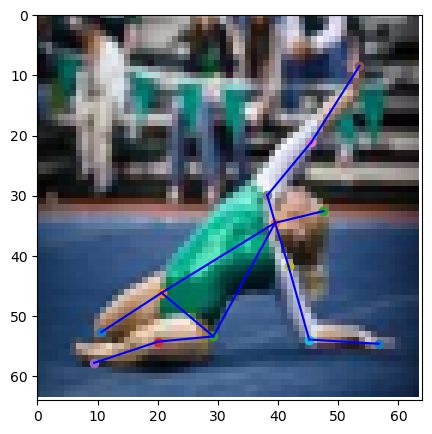

In [6]:
# Fonction d'affichage d'une image et de son label associé

def print_data(x,y,i):

    if y.shape[1] < 3:
        y_new = np.ones((y.shape[0], 3, y.shape[2]))
        y_new[:,0:2,:] = y
        y = y_new

    plt.figure(figsize=(5, 5))
    plt.imshow(x[i]/255)
    for j in range(0,14):
        if y[i, 2, j] == 1:
            plt.scatter(y[i,0,j],y[i,1,j],label=labels.get(j))

    # Jambe droite      
    if (y[i, 2, 0] + y[i, 2, 1] == 2):
        plt.plot(y[i,0,0:2],y[i,1,0:2],'b')
    # Cuisse droite      
    if (y[i, 2, 1] + y[i, 2, 2] == 2):
        plt.plot(y[i,0,1:3],y[i,1,1:3],'b')
    # Bassin     
    if (y[i, 2, 2] + y[i, 2, 3] == 2):
        plt.plot(y[i,0,2:4],y[i,1,2:4],'b')
    # Cuisse gauche      
    if (y[i, 2, 3] + y[i, 2, 4] == 2):
        plt.plot(y[i,0,3:5],y[i,1,3:5],'b')
    # Jambe gauche      
    if (y[i, 2, 4] + y[i, 2, 5] == 2):
        plt.plot(y[i,0,4:6],y[i,1,4:6],'b')
    # Avant-bras droit      
    if (y[i, 2, 6] + y[i, 2, 7] == 2):
        plt.plot(y[i,0,6:8],y[i,1,6:8],'b')
    # Bras droit      
    if (y[i, 2, 7] + y[i, 2, 8] == 2):
        plt.plot(y[i,0,7:9],y[i,1,7:9],'b')
    # Bras gauche     
    if (y[i, 2, 9] + y[i, 2, 10] == 2):
        plt.plot(y[i,0,9:11],y[i,1,9:11],'b')
    # Avant-bras gauche      
    if (y[i, 2, 10] + y[i, 2, 11] == 2):
        plt.plot(y[i,0,10:12],y[i,1,10:12],'b') 
    # Buste droit
    x1=[y[i,0,2],y[i,0,12]]
    y1=[y[i,1,2],y[i,1,12]]
    if (y[i, 2, 2] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Buste gauche
    x1=[y[i,0,3],y[i,0,12]]
    y1=[y[i,1,3],y[i,1,12]]
    if (y[i, 2, 3] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Omoplate droite
    x1=[y[i,0,8],y[i,0,12]]
    y1=[y[i,1,8],y[i,1,12]]
    if (y[i, 2, 8] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Omoplate gauche
    x1=[y[i,0,9],y[i,0,12]]
    y1=[y[i,1,9],y[i,1,12]]
    if (y[i, 2, 9] + y[i, 2, 12] == 2):
        plt.plot(x1, y1,'b')
    # Tete     
    if (y[i, 2, 12] + y[i, 2, 13] == 2):
        plt.plot(y[i,0,12:14],y[i,1,12:14],'b')

    plt.axis([0, x.shape[1], x.shape[2], 0])
    plt.show()
    #plt.legend()

# Affichage aléatoire d'une image
print_data(x,y,np.random.randint(x.shape[0]-1))

Si nous formulons ce problème comme une régression, nous allons utiliser pour évaluer nos réseaux de neurones l'erreur quadratique moyenne (fonction *MSE*). Cette fonction sera parfaite comme fonction de perte, mais elle ne permet pas d'appréhender les résultats de manière satisfaisante.

Une métrique commune en estimation de posture est le **PCK0.5**, pour *Percentage of Correct Keypoints*. *0.5* correspond à un seuil en-deça duquel on considère qu'un joint est correctement estimé. Cette question du seuil est particulièrement sensible car il faut utiliser une valeur qui soit valable pour n'importe quelle image. La personne considérée peut apparaître plus ou moins largement sur l'image, de face ou de profil, ce qui fait qu'une erreur de prédiction sur un joint peut avoir une importance très grande ou très faible selon les cas.

Pour résoudre cette ambiguïté, on considère dans la métrique du **PCK0.5** que la référence est la taille de la tête, définie par la distance entre le joint du cou et le joint de la tête sur la vérité terrain. Un joint prédit par le réseau sera considéré correct s'il est situé à une distance inférieure à la moitié (*0.5*) de la taille de la tête par rapport au joint réel. (**[[Andriluka et al.]](https://openaccess.thecvf.com/content_cvpr_2014/html/Andriluka_2D_Human_Pose_2014_CVPR_paper.html)** _2D Human Pose Estimation: New Benchmark and State of the Art Analysis_)

In [7]:
import numpy.matlib 

In [8]:
# Calcul du "Percentage of Correct Keypoint" avec seuil alpha :
# On compte corrects les joints pour lesquels la distance entre valeurs réelle et prédite 
# est inférieure à alpha fois la dimension de la tête (c'est un peu arbitraire...)
# On ne comptera pas les joints invisibles.
# y_true est de dimension Nx3x14 et y_pred Nx2x14 (le réseau ne prédit pas la visibilité)

def compute_PCK_alpha(y_true, y_pred, alpha=0.5):
    # Calcul des seuils ; la taille de la tête est la distance entre joints 12 et 13
    head_sizes = np.sqrt( np.square(y_true[:,0,13]-y_true[:,0,12]) + np.square(y_true[:,1,13]-y_true[:,1,12]) )
    thresholds = alpha * head_sizes
    thresholds = np.matlib.repmat(np.expand_dims(thresholds, 1), 1, 14)

    # Calcul des distances inter-joints
    joints_distances = np.sqrt( np.square(y_true[:,0,:]-y_pred[:,0,:]) + np.square(y_true[:,1,:]-y_pred[:,1,:]) )

    # Visibilité des joints de la vérité terrain
    visibility = y_true[:,2,:]
    
    total_joints = np.count_nonzero(visibility==1)
    correctly_predicted_joints = np.count_nonzero( np.logical_and(joints_distances<thresholds, visibility == 1) )
    
    return correctly_predicted_joints/total_joints

Comme dit précédemment, on va utiliser l'erreur quadratique moyenne (*[MSE](https://en.wikipedia.org/wiki/Mean_squared_error)*) comme fonction de coût pour entraîner notre réseau de neurones, et on peut également utiliser l'erreur absolue moyenne (*[MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)*) pour obtenir une estimation plus fine des performances de notre réseau pendant l'entraînement (on obtient une erreur moyenne en pixels, ce qui est plus simple à interpréter).

Il y a cependant une subtilité importante évoquée un peu plus haut : certains joints sont invisibles, et ont des coordonnées négatives (pour, il faut l'avouer, une raison un peu inexplicable). Il est important de ne pas affecter l'apprentissage en faisant prédire ces valeurs négatives, insensées, au réseau. 

On doit donc implanter nous-même notre propre fonction de coût, qui ne va pas prendre en compte les joints invisibles. Pour cela, il faut savoir que la vérité-terrain contient en fait 3 valeurs pour chaque joint : les 2 premières sont ses coordonnées sur l'image, la 3e représente la visibilité du joint (1 s'il est visible, 0 sinon).

La fonction *custom_mse*, définie juste en-dessous, réalise cette opération. Prenez le temps de comprendre ce qu'il s'y passe. 

**Remarque importante** : Ce code fait appel à des fonctions particulières du Backend de `Keras`, dont vous trouverez les détails sur [cette page](https://keras.rstudio.com/articles/backend.html). Ces fonctions doivent traiter des tenseurs, de type _tensor_ (et pas des tableaux _numpy_), car elles seront appelées pendant l'entraînement sur des variables internes à `Tensorflow`. Les fonctions utilisables sont également limitées car il faut pouvoir dériver la fonction *custom_mse* pour la rétropropagation des gradients.

In [9]:
import tensorflow.keras.backend as K

2024-09-16 16:29:00.421879: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 16:29:00.423216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 16:29:00.445042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 16:29:00.445066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 16:29:00.445082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [10]:
# y_true : vérité terrain de dimension B x 3 x 14
# y_pred : une prédiction de dimension B x 2 x 14 (on ne prédit pas la visibilité)
# B est le nombre d'images considérées (par exemple, pourra être la taille d'un mini-batch)

def custom_mse(y_true, y_pred):
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))
  
    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))
    
    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)  
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]
    
    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)
    
    # Calcul de la MSE
    return K.mean( K.square(y_pred_visible[:,0]-y_true_visible[:,0]) + K.square(y_pred_visible[:,1]-y_true_visible[:,1]) )

Si vous avez bien compris le code de *custom_mse*, vous devriez pouvoir sans trop de problèmes écrire le code pour la fonction *custom_mae* ci-dessous :

In [11]:
# y_true : vérité terrain de dimension B x 3 x 14
# y_pred : une prédiction de dimension B x 2 x 14 (on ne prédit pas la visibilité)
# B est le nombre d'images considérées (par exemple, pourra être la taille d'un mini-batch)

def custom_mae(y_true, y_pred):
    # Changement de dimension : Bx3x14 -> Bx14x3
    y_true = K.permute_dimensions(y_true, (0, 2, 1))
    # Changement de dimension : Bx14x3 -> (B*14)x3
    y_true = K.reshape(y_true, shape=(-1, 3))
    
    # Changement de dimension : Bx2x14 -> Bx14x2
    y_pred = K.permute_dimensions(y_pred, (0, 2, 1))
    # Changement de dimension : Bx14x2 -> (B*14)x2
    y_pred = K.reshape(y_pred, shape=(-1, 2))
    
    # Détermination de l'indices des joints visibles
    visible = K.greater_equal(y_true[:, 2], 1)
    indices = K.arange(0, K.shape(y_true)[0])
    indices_visible = indices[visible]
    
    # Sélection des vérité-terrains et prédictions des joints visibles
    y_true_visible = K.gather(y_true[:,0:2], indices_visible)
    y_pred_visible = K.gather(y_pred, indices_visible)
    
    # Calcul de la MAE
    return K.mean( K.abs(y_pred_visible[:,0]-y_true_visible[:,0]) + K.abs(y_pred_visible[:,1]-y_true_visible[:,1]) )

In [12]:
# %load solutions/custom_mae.py

Comme d'habitude, on peut monitorer l'entraînement grâce à la fonction suivante (adaptée à nos fonctions *custom_mse* et *custom_mae* définies juste avant) : 

In [13]:
def plot_training_analysis(history):
    mae = history.history['custom_mae']
    val_mae = history.history['val_custom_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.subplot(1,2,1)
    plt.plot(epochs, mae, 'b', linestyle="--",label='Training MAE')
    plt.plot(epochs, val_mae, 'g', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## À vous de jouer

Pour tenter de résoudre le problème, vous pouvez suivre les étapes suivantes : 

- Simplifier le problème en traitant 10 imagettes (par exemple de dimension $64 \times 64$) et construire un réseau qui surapprend parfaitement (qui diminue la perte jusqu'à quasiment 0 $\leadsto$ `simple_CNN.py`)
- Ajouter des images (~1000) et éventuellement recalibrer votre réseau pour à nouveau, obtenir un sur-apprentissage
- Commencer à corriger le sur-apprentissage en ajoutant de la régularisation (notamment sur les couches denses)
- Et enfin, utiliser l'ensemble de la base de données pour diminuer le sur-apprentissage au maximum

In [17]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, Reshape
from keras import regularizers
from sklearn.model_selection import train_test_split

In [18]:

def simple_CNN(image_size=64):
    model = Sequential()
    
    model.add(Conv2D(32,(3,3), padding='same', input_shape=(image_size,image_size,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(96,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(28, activation='linear'))
    model.add(Reshape((2,14)))
    
    return model

Epoch 1/100
4/4 [==============================] - 1s 46ms/step - loss: 1170.4017 - custom_mae: 39.0461 - val_loss: 611.9292 - val_custom_mae: 28.1722
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 419.6694 - custom_mae: 23.2152 - val_loss: 529.9178 - val_custom_mae: 27.6872
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 308.7233 - custom_mae: 20.6328 - val_loss: 444.7678 - val_custom_mae: 24.6707
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 304.5348 - custom_mae: 19.3558 - val_loss: 363.8910 - val_custom_mae: 22.2404
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 282.2254 - custom_mae: 18.9034 - val_loss: 281.5068 - val_custom_mae: 19.3034
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 202.2133 - custom_mae: 15.5709 - val_loss: 288.7807 - val_custom_mae: 20.0257
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: 196.3490 - custom_mae: 15.0

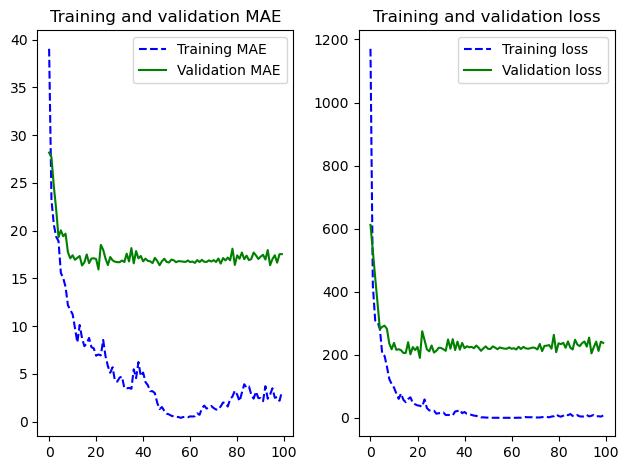

In [24]:
# Création des données d'entrainement et de test
num_images = 10
x, y = load_data(image_size=64, num_images=num_images)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# Création du modèle
model = simple_CNN(image_size=64)

# Entrainement du réseau
optim = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss=custom_mse, metrics=[custom_mae])

history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_data=(x_val, y_val))

# Evaluation du modèle
plot_training_analysis(history)

In [25]:
def complex_CNN(image_size=64):
    model = Sequential()
    
    model.add(Conv2D(32,(3,3), padding='same', input_shape=(image_size,image_size,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(96,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(28, activation='linear'))
    model.add(Reshape((2,14)))
    
    return model

# **Approche n°2** : Prédiction de cartes de chaleur

Dans cette partie, nous allons utiliser une autre formulation du problème, présentée pendant le cours. Plutôt que de prédire directement la position pixellique des joints, nous allons prédire des cartes de probabilité de la position des joints, comme illustré ci-dessous. Pour ce faire, il nous faudra tester des architectures de réseau de neurones différentes, s'inspirant de celles utilisées en segmentation d'image.

![Texte alternatif…](img/heatmap.png)

## Fonctions utiles

La fonction suivante permet de créer une carte de chaleur de la dimension voulue, avec une gaussienne centrée en un point donné.

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
def heat_point(ind_x, ind_y, heatmap_size):
    heat_point=np.zeros((heatmap_size,heatmap_size))
    heat_point[ind_x][ind_y] = 1
    
    return gaussian_filter(heat_point, round(heatmap_size/20))


h_m = heat_point(14, 44, 64)
plt.imshow(h_m)
plt.show()

On peut ensuite retrouver la position du point le plus "chaud", en utilisant la commande suivante : 

In [ ]:
np.unravel_index(np.argmax(h_m), h_m.shape) 

On peut donc définir les 2 fonctions suivantes permettant de générer les cartes de chaleur à partir des coordonnées de joints, et vice-versa.

In [ ]:
def coord2heatmap(y, heatmap_size):
    heatmap = np.zeros((y.shape[0], 14, heatmap_size, heatmap_size))
    for img in range(y.shape[0]):
        for j in range(14):
            ind_x = int(y[img][1][j])
            ind_y = int(y[img][0][j])
            #print(ind_x, ind_y)
            if ind_x >= 0 and ind_y >= 0 and ind_x < heatmap_size and ind_y < heatmap_size:
                heatmap[img][j] = heat_point(ind_x, ind_y, heatmap_size)
    heatmap = np.transpose(heatmap, (0, 2, 3, 1))
    heatmap = heatmap / np.max(heatmap)
    return heatmap


def heatmap2coord(heatmap):
    y = np.ones((heatmap.shape[0], 3, 14))

    heatmap = np.transpose(heatmap, (0, 3, 1, 2))
    for img in range(y.shape[0]):
        for j in range(14): 
            max_heat = np.unravel_index(np.argmax(heatmap[img][j]), heatmap[img][j].shape)  
            y[img][0][j] = max_heat[1]
            y[img][1][j] = max_heat[0]
            if max_heat[0] == 0 and max_heat[1] == 0:
                y[img][2][j] = 0 # Le joint est invisible
    return y

**Todo** : Ecrivez une fonction permettant d'affichager des cartes de 

On affichera pour `rows` images $x$ et carte de chaleur $y$ associée : (i) l'image, (ii) tous les joints simultanément, (iii) seulement la tête, (iv) seulement le coude droit, (v) seulement le genou gauche.

La cellule ci-dessous donne un exemple de résultat attendu.

In [ ]:
img = Image.open('img/print_heatmap.png')
plt.imshow(img)
plt.show()

In [ ]:
def print_heatmap(x, y, rows=3):
    [...]

In [ ]:
# %load solutions/print_heatmap.py

Les lignes suivantes vous permettront de démarrer simplement : 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Chargement des données : on choisit une dimension d'image et de carte de chaleur de 64x64
image_size = 64
heatmap_size = 64

# Chargement de seulement 1000 images
x, y = load_data(image_size=image_size, num_images=1000) 

# Normalisation des données
x = x/255

# Chargement des données : 1000 images d'apprentissage, 100 de validation, 100 de test    
x_train, x_gen, y_train, y_gen = train_test_split(x, y, test_size=1/10, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_gen, y_gen, test_size=1/2, random_state=1)

# Calcul des cartes de chaleur (prend un peu de temps)
y_hm_train = coord2heatmap(y_train, heatmap_size)
y_hm_val = coord2heatmap(y_val, heatmap_size)
y_hm_test = coord2heatmap(y_test, heatmap_size)

# Affichage de quelques exemples
print_heatmap(x_train, y_hm_train)

Pour vous aider pour la suite, voici ci-dessous une implémentation du réseau UNet, vu en cours sur la segmentation.

![Texte alternatif…](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

A vous de l'**adapter** afin qu'il soit pertinent pour le problème courant.

In [ ]:
import keras
from keras.layers import *
from keras import *

In [ ]:
def create_unet(image_size=572):
    input_layer=Input((image_size, image_size, 1))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input_layer, conv10)

    return model

In [ ]:
model = create_unet(image_size=64)
model.summary()

## À vous de jouer

Essayez d'adapter le réseau Unet ($\leadsto$ `modif_unet.py`) à votre problème, puis de l'entraîner sur le petit ensemble de données x_train. 

Plusieurs remarques (**à lire attentivement**) : 



*  Vous devriez observer beaucoup moins de sur-apprentissage ! Si vos prédictions sur l'ensemble de validation sont aberrantes, c'est que vous avez un bug !!
*   Se pose la question de la formulation du problème : dans la mesure où 
les cartes de chaleur sont assimilables à des cartes de probabilité (entre 0 et 1), on peut certes choisir de conserver une formaulation du problème basée sur la régression, mais il est probablement beaucoup plus optimal de formuler le problème comme de la classification binaire.
*   Il y a cependant toujours du sur-apprentissage. Vous pouvez donc augmenter la taille de la base de données à 10000, puis tester différentes possibilités pour diminuer ce sous-apprentissage, notamment l'augmentation de données. Les cellules suivantes vous fournissent des éléments permettant de mettre en place cette augmentation.

## Code fourni pour l'augmentation de données

Vous trouverez ici quelques éléments qui vous permettront de mettre en place de l'augmentation de données. 
Attention l'augmentation rend l'apprentissage plus difficile et en fait plus lent, et vous devrez peut-être augmenter un peu la capacité de votre UNet et le nombre d'epochs pour éviter le sous-apprentissage.

[`Albumentation`](https://albumentations.ai/) est une librairie implémentant un grand nombre d'opérations d'augmentation de données. Dans le code suivant, deux types d'augmentation sont définies : des transformations spatiales (`ShiftScaleRotate`), et des transformations colorimétriques. 

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

In [ ]:
import cv2 as cv
from albumentations import (Compose, RandomBrightnessContrast, RandomGamma, ShiftScaleRotate)

In [ ]:
AUGMENTATIONS_TRAIN = Compose([
    ShiftScaleRotate(p=0.5),
    RandomBrightnessContrast(contrast_limit=0.2, brightness_limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
])

La classe `Sequence` permet de définir l'accès aux données d'entraînement de manière personnalisée, afin par exemple d'implanter des augmentations particulières (c'est le cas ici).
Prenez le temps de comprendre la synthaxe utilisée.

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class LSPDSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0]) 
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder aux données 
        # et sont randomisés à chaque epoch pour varier la composition des batches au cours de l'entraînement

        
    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int( np.ceil(len(self.x) / float(self.batch_size)) )

    
    # Application de l'augmentation de données à chaque image du batch et aux cartes de probabilités associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros(bx.shape)
        batch_y = np.zeros(by.shape)
        # Pour chaque image du batch
        for i in range(len(bx)):
            masks = []
            # Les 14 masques associés à l'image sont rangés dans une liste pour 
            # pourvoir être traités par la librairie Albumentation
            for n in range(by.shape[3]):
                masks.append(by[i,:,:,n])

            img = bx[i]
            # Application de l'augmentation à l'image et aux masques
            transformed = self.augment(image=img, masks=masks)
            batch_x[i] = transformed['image']
            batch_y_list = transformed['masks']

            # Reconstitution d'un tenseur à partir des masques augmentés
            for k in range(by.shape[3]):
                batch_y[i,:,:,k] = batch_y_list[k]

        return batch_x, batch_y

    
    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)

        return np.array(batch_x), np.array(batch_y)

    
    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

In [ ]:
x_train = x_train.astype(np.float32)
y_hm_train = y_hm_train.astype(np.float32)

# Instanciation d'une Sequence
train_gen = LSPDSequence(x_train, y_hm_train, 16, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

print_heatmap(batch_x, batch_y)

Pour utiliser cette séquence il vous suffit d'appeler la fonction `fit` de la manière suivante :
```python
model.fit(train_gen, ...)
```